In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from z3 import *
import torch
import time
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import combinations, permutations
import tqdm

from Z3_Tools import *
from utils import *
from models import * 

import importlib, models
importlib.reload(models)
from models import *


## Enumerate Propositional Logic Statements

In [2]:
## Generate all_formulas more cleverly 
ATOMS = ["A", "B", "C", "D", "E"] 

lits = ATOMS + [f"~{a}" for a in ATOMS]
imps = [f"{p}->{q}" for p, q in permutations(ATOMS, 2)]      
ands = [f"{p}&{q}"   for p, q in combinations(ATOMS, 2)]  
ors  = [f"{p}|{q}"   for p, q in combinations(ATOMS, 2)] 

ALL_FORMULAS = lits + imps + ands + ors
print(np.array(ALL_FORMULAS))
print(len(ALL_FORMULAS))

['A' 'B' 'C' 'D' 'E' '~A' '~B' '~C' '~D' '~E' 'A->B' 'A->C' 'A->D' 'A->E'
 'B->A' 'B->C' 'B->D' 'B->E' 'C->A' 'C->B' 'C->D' 'C->E' 'D->A' 'D->B'
 'D->C' 'D->E' 'E->A' 'E->B' 'E->C' 'E->D' 'A&B' 'A&C' 'A&D' 'A&E' 'B&C'
 'B&D' 'B&E' 'C&D' 'C&E' 'D&E' 'A|B' 'A|C' 'A|D' 'A|E' 'B|C' 'B|D' 'B|E'
 'C|D' 'C|E' 'D|E']
50


## Goal-Conditioned Theorem Prover

In [3]:
## Make sure verify_step_small can parse all tiny steps ... 
print(verify_step_small(['A', 'A->B', 'B->C'], 'B'))
print(verify_step_small(['A', 'A->B', 'B->C'], 'C'))
print(verify_step_small(['A&B'], 'A'))
print(verify_step_small(['A', 'B'], 'A&B'))
print(verify_step_small(['A'], 'A|B'))
print(verify_step_small(['A|B', '~B'], 'A'))

# Can enforce other rules of logic later ... 
print(verify_step_small(['A->B', '~B'], '~A'))
print(verify_step_small(['A|B', 'A->C', 'B->C'], 'C'))

True
False
True
True
True
True
False
False


In [4]:
## Use small steps to find *true* shortest paths for proofs
print(find_shortest_proof(['A', 'A->B', 'B->C'], 'C', ALL_FORMULAS, 5))
print(find_shortest_proof(['A', 'A->B', 'B->C', 'C->A'], 'A&B', ALL_FORMULAS, 5))

['B', 'C']
['B', 'A&B']


# Load & Prepare Data

In [5]:
data = np.load("Data/proof_data_steps.npz", allow_pickle=True)
X_states = data["X_states"].tolist()
X_props  = data["X_props"].tolist()
Y_labels = data["Y_labels"].tolist()
print(len(X_states), len(X_props), len(Y_labels))

1881508 1881508 1881508


In [6]:
print(type(X_states[5]))

<class 'frozenset'>


In [122]:
## Split up Training Data by depth
depths = []
for i, (state, goal) in enumerate(zip(X_states, X_props)):
    if i%200000==0: print(f'On state {i} of {1000000}')
    path = find_shortest_proof(list(state), goal, ALL_FORMULAS, 5)
    depths.append(len(path))
    if i==1000000: break

On state 0 of 1000000
On state 200000 of 1000000
On state 400000 of 1000000
On state 600000 of 1000000
On state 800000 of 1000000
On state 1000000 of 1000000


In [160]:
print(depths.count(5))
print(depths[:30])
np.savez_compressed(
    "depths.npz",
    depths=np.array(depths),
)

4265
[1, 1, 2, 1, 1, 3, 4, 3, 3, 4, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 2, 3, 3]


In [137]:
depths = np.load("Data/depths.npz")["depths"]
print(list(depths).count(5)*0.2)
print(1/np.sqrt(853))

853.0
0.034239347869895034


In [7]:
## Define the indices of data with depth = d
indices1 = [i for i, d in enumerate(depths) if d==1]
indices2 = [i for i, d in enumerate(depths) if d==2]
indices3 = [i for i, d in enumerate(depths) if d==3]
indices4 = [i for i, d in enumerate(depths) if d==4]
indices5 = [i for i, d in enumerate(depths) if d==5]

## Split X_train into 5 groups  
def subset_dataset(idxs):
    Xs = [X_states[i] for i in idxs]  # state
    Xp = [X_props[i]  for i in idxs]  # prop
    Yl = [Y_labels[i] for i in idxs]  # label
    return Xs, Xp, Yl

X1_states, X1_props, Y1 = subset_dataset(indices1)
X2_states, X2_props, Y2 = subset_dataset(indices2)
X3_states, X3_props, Y3 = subset_dataset(indices3)
X4_states, X4_props, Y4 = subset_dataset(indices4)
X5_states, X5_props, Y5 = subset_dataset(indices5)

In [8]:
def OneHotPrepare(X_states, X_props, Y_labels, ALL_FORMULAS):
    
    OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}
    X_props_num = np.array([OneHot_Map[p] for p in X_props])
    Y_labels_num = np.array([OneHot_Map[p] for p in Y_labels])
    
    # one-hot
    X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_num]  # defining a repeating list of I rows ... 
    X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])
    Y_labels_1h = np.eye(len(ALL_FORMULAS))[Y_labels_num]
    
    return [X_states_1h, X_props_1h, Y_labels_1h]

In [9]:
## 5 separate groups of training data
X1_states_1h, X1_props_1h, Y1_labels_1h = OneHotPrepare(X1_states, X1_props, Y1, ALL_FORMULAS)
X2_states_1h, X2_props_1h, Y2_labels_1h = OneHotPrepare(X2_states, X2_props, Y2, ALL_FORMULAS)
X3_states_1h, X3_props_1h, Y3_labels_1h = OneHotPrepare(X3_states, X3_props, Y3, ALL_FORMULAS)
X4_states_1h, X4_props_1h, Y4_labels_1h = OneHotPrepare(X4_states, X4_props, Y4, ALL_FORMULAS)
X5_states_1h, X5_props_1h, Y5_labels_1h = OneHotPrepare(X5_states, X5_props, Y5, ALL_FORMULAS)

## Define X1,2,3,4 and Y1,2,3,4
X1 = np.concatenate([X1_states_1h, X1_props_1h], axis=1)
X2 = np.concatenate([X2_states_1h, X2_props_1h], axis=1)
X3 = np.concatenate([X3_states_1h, X3_props_1h], axis=1)
X4 = np.concatenate([X4_states_1h, X4_props_1h], axis=1)
X5 = np.concatenate([X5_states_1h, X5_props_1h], axis=1)

print(len(X1), len(X2), len(X3), len(X4), len(X5))

Y1 = np.argmax(Y1_labels_1h, axis=1)
Y2 = np.argmax(Y2_labels_1h, axis=1)
Y3 = np.argmax(Y3_labels_1h, axis=1)
Y4 = np.argmax(Y4_labels_1h, axis=1)
Y5 = np.argmax(Y5_labels_1h, axis=1)

# cumulative concatenations for training
X12  = np.concatenate([X1, X2], axis=0)
Y12  = np.concatenate([Y1, Y2], axis=0)

X123 = np.concatenate([X1, X2, X3], axis=0)
Y123 = np.concatenate([Y1, Y2, Y3], axis=0)

X1234 = np.concatenate([X1, X2, X3, X4], axis=0)
Y1234 = np.concatenate([Y1, Y2, Y3, Y4], axis=0)

X12345 = np.concatenate([X1, X2, X3, X4, X5], axis=0)
Y12345 = np.concatenate([Y1, Y2, Y3, Y4, Y5], axis=0)

337962 493770 125044 38960 4265


In [10]:
## Prepare data for Transformer
def make_transformer_tokens(X_states_1h, X_props_1h, max_known=10):
    N, F = X_states_1h.shape
    T = max_known + 1
    X_T = np.zeros((N, T, F), dtype=np.float32)

    # For each proof, convert X_states_1h -> X_T  ... (N, F) -> (N, T, F)
    for i in range(N):
        known_idxs = np.where(X_states_1h[i] == 1)[0]
        known_idxs = np.sort(known_idxs)[-max_known:]             # formula indices in the state
        for t, j in enumerate(known_idxs):
            X_T[i, t, j] = 1.0                                     # one token per known formula
        X_T[i, -1, :] = X_props_1h[i]                              # last token = goal one-hot

    return X_T

X1_T = make_transformer_tokens(X1_states_1h, X1_props_1h, max_known=10)
X2_T = make_transformer_tokens(X2_states_1h, X2_props_1h, max_known=10)
X3_T = make_transformer_tokens(X3_states_1h, X3_props_1h, max_known=10)
X4_T = make_transformer_tokens(X4_states_1h, X4_props_1h, max_known=10)
X5_T = make_transformer_tokens(X5_states_1h, X5_props_1h, max_known=10)

# cumulative concatenations for training
X12_T  = np.concatenate([X1_T, X2_T], axis=0)
X123_T = np.concatenate([X1_T, X2_T, X3_T], axis=0)
X1234_T = np.concatenate([X1_T, X2_T, X3_T, X4_T], axis=0)
X12345_T = np.concatenate([X1_T, X2_T, X3_T, X4_T, X5_T], axis=0)


print(np.shape(X1_states_1h[:2]))
print(np.shape(X1_T[:2]))

(2, 50)
(2, 11, 50)


# Train

0 0.29125685814010505
3 3.889054856883718e-05
6 5.060023262020951e-06
9 8.319144018898713e-07
0 0.29268506592275945
3 0.0060080564723719925
6 0.0020568611270046075
9 0.0014061690212361201
0 0.31306792765950014
3 0.009904958731034792
6 0.005093529868873602
9 0.0031969079396533336
0 0.32737972667862403
3 0.013513906008751984
6 0.007337715759273912
9 0.005123002481278496
0 0.3446372912800312
3 0.015838629314489663
6 0.009122877363068983
9 0.006134981402659323


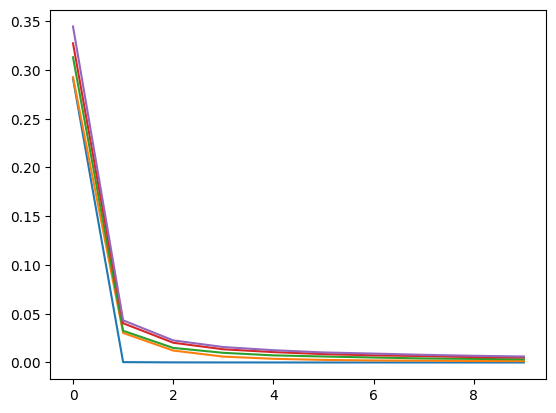

In [159]:
# Train the MLPs  
es = 10;
model1, test1 = train_model(X1,    Y1,    len(ALL_FORMULAS), epochs=es, batch_size=256, loss_fn=nn.CrossEntropyLoss(), printevery=3)
model2, test2 = train_model(X12,   Y12,   len(ALL_FORMULAS), epochs=es, batch_size=256, loss_fn=nn.CrossEntropyLoss(), printevery=3)
model3, test3 = train_model(X123,  Y123,  len(ALL_FORMULAS), epochs=es, batch_size=256, loss_fn=nn.CrossEntropyLoss(), printevery=3)
model4, test4 = train_model(X1234, Y1234, len(ALL_FORMULAS), epochs=es, batch_size=256, loss_fn=nn.CrossEntropyLoss(), printevery=3)
model5, test5 = train_model(X12345, Y12345, len(ALL_FORMULAS), epochs=es,batch_size=256, loss_fn=nn.CrossEntropyLoss(), printevery=3)

0 0.21901357317094422
3 1.8339413110032204e-05
6 2.1577698435748392e-06
9 3.3458388775230823e-07
12 5.632307865675874e-08
0 0.17692096208075378
3 0.005960566540666255
6 0.003740321730753827
9 0.0025261608740687275
12 0.0020894842678893834
0 0.1924940690823591
3 0.009447409039336642
6 0.005101051723939592
9 0.003800858936790208
12 0.0029602338718662004
0 0.19168142195162907
3 0.012339860408612343
6 0.007232964454744568
9 0.0050352302407441684
12 0.003967663597343172
0 0.19432831301659345
3 0.01227279479100369
6 0.007083765187085373
9 0.00516866520975047
12 0.004024977653836104


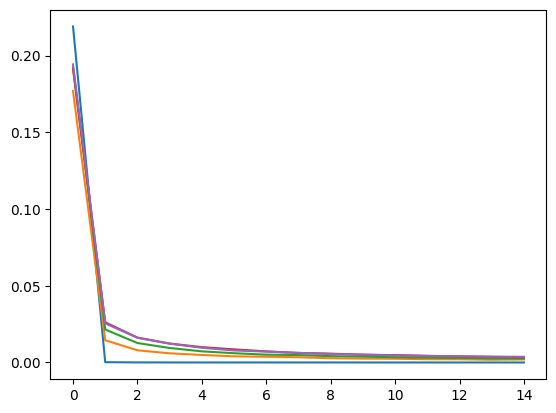

In [160]:
# Train the Deep Sets
es = 15;
modelDS1, testDS1 = train_model(X1, Y1, len(ALL_FORMULAS), batch_size=256, 
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_deepsets=True, printevery=3)
modelDS2, testDS2 = train_model(X12, Y12, len(ALL_FORMULAS), batch_size=256, 
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_deepsets=True, printevery=3)
modelDS3, testDS3 = train_model(X123, Y123, len(ALL_FORMULAS),batch_size=256,  
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_deepsets=True, printevery=3)
modelDS4, testDS4 = train_model(X1234, Y1234, len(ALL_FORMULAS), batch_size=256, 
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_deepsets=True, printevery=3)
modelDS5, testDS5 = train_model(X12345, Y12345, len(ALL_FORMULAS), batch_size=256, 
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_deepsets=True, printevery=3)

0 0.19531979442279088
3 7.30241539849847e-05
6 1.0069328081232967e-05
9 1.7258254938154294e-06
12 2.871799704311553e-07
0 0.2644413468562038
3 0.00850434281217959
6 0.004109741615899708
9 0.002456117341616904
12 0.0019339788826429217
0 0.32707446540993085
3 0.02279409379712572
6 0.010187495772134965
9 0.006222466157681717
12 0.004532257900083816
0 0.3176721705219062
3 0.02789391820092806
6 0.015148300778916352
9 0.010938842266251535
12 0.008829170480998107
0 0.3265527748429775
3 0.02644000647496432
6 0.00879747526657302
9 0.005391377424329985
12 0.004344929908271879


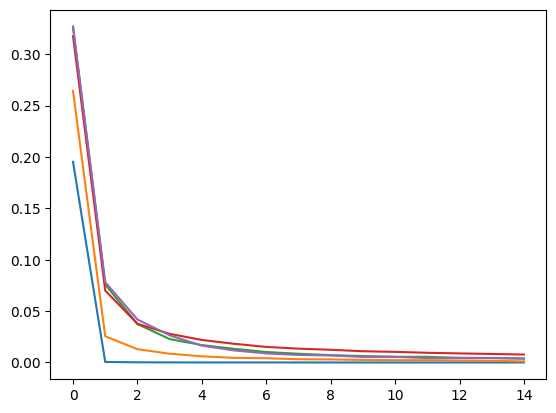

In [13]:
# Train the transformer models  
es = 15; bs = 256
modelTR1, testTR1 = train_model(X1_T, Y1, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR2, testTR2 = train_model(X12_T, Y12, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR3, testTR3 = train_model(X123_T, Y123, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR4, testTR4 = train_model(X1234_T, Y1234, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR5, testTR5 = train_model(X12345_T, Y12345, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)


0 0.1476493554492163
3 6.725546826987073e-05
6 9.177675938646593e-06
9 1.5307090754381977e-06
0 0.13422372012356523
3 0.004148195401317147
6 0.0026492614718374237
9 0.001879767005436521
0 0.16049274897069446
3 0.005155551149654762
6 0.0031275958234396333
9 0.002496613543366747
0 0.17522729808276172
3 0.008836030684285899
6 0.0053843614413744845
9 0.003691406309974944
0 0.17169150985360146
3 0.010611724559725262
6 0.006240239264754346
9 0.004602423212246504


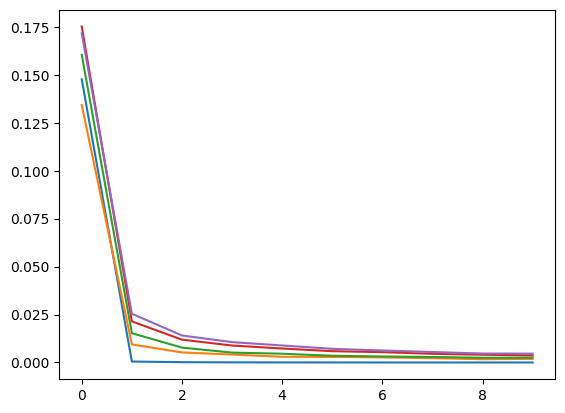

In [149]:
# Train the transformer models 2222222  
es = 10; bs = 256
modelTR1, testTR1 = train_model(X1_T, Y1, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR2, testTR2 = train_model(X12_T, Y12, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR3, testTR3 = train_model(X123_T, Y123, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR4, testTR4 = train_model(X1234_T, Y1234, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)
modelTR5, testTR5 = train_model(X12345_T, Y12345, len(ALL_FORMULAS), batch_size=bs,
                                epochs=es, loss_fn=nn.CrossEntropyLoss(), use_transformer=True, printevery=3)


In [150]:
Xte1, Yte1 = test1
Xte2, Yte2 = test2
Xte3, Yte3 = test3
Xte4, Yte4 = test4
Xte5, Yte5 = test5

XteDS1, YteDS1 = testDS1
XteDS2, YteDS2 = testDS2
XteDS3, YteDS3 = testDS3
XteDS4, YteDS4 = testDS4
XteDS5, YteDS5 = testDS5

XteTR1, YteTR1 = testTR1
XteTR2, YteTR2 = testTR2
XteTR3, YteTR3 = testTR3
XteTR4, YteTR4 = testTR4
XteTR5, YteTR5 = testTR5

print(len(Xte1), len(Xte2), len(Xte3), len(Xte4), len(Xte5) - len(Xte4))

67593 166347 191356 199148 853


In [151]:
# def test_example(num, Xte):
#     state_bits = Xte[num][:len(ALL_FORMULAS)]
#     goal_bits  = Xte[num][len(ALL_FORMULAS):]
#     state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
#     goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]
# #     print("state:", state_formulas)
# #     print("goal:", goal_formula)
# #     print("label:", Yte[2])
#     return {'state': state_formulas, 'goal': goal_formula}

def test_example(num, Xte, transformer=False):
    F = len(ALL_FORMULAS)

    if not transformer:
        state_bits = Xte[num][:F]
        goal_bits  = Xte[num][F:]
        state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
        goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]
        return {'state': state_formulas, 'goal': goal_formula}

    else:
        tokens = Xte[num]                # (T, F), last token is goal one-hot
        state_tokens = tokens[:-1]       # (T-1, F) includes padding zeros
        goal_bits = tokens[-1]           # (F,)

        state_formulas = [ALL_FORMULAS[int(np.argmax(row))]
                          for row in state_tokens if row.sum() > 0]
        goal_formula = ALL_FORMULAS[int(np.argmax(goal_bits))]
        return {'state': state_formulas, 'goal': goal_formula}

In [152]:
test_example(4, Xte3)

{'state': ['B->D', 'C->B', 'E->C', 'D&E', 'C|E'], 'goal': 'C'}

## Improved Theorem Prover

In [153]:
# Not even sure if this is in train or test set .... 
state_check = encode_state(['A', 'A->B', 'B->C'], ALL_FORMULAS)
goal_check =  encode_state(['C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])

x_tokens = np.zeros((6, len(ALL_FORMULAS)), dtype=np.float32)
idxs = np.where(state_check == 1)[0]
x_tokens[np.arange(len(idxs)), idxs] = 1.0
x_tokens[-1] = goal_check

tt = torch.tensor(x_tokens[None, :, :], dtype=torch.float32)
logits = modelTR2(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[ -3.7438,  13.0267,  -2.0079,   3.4655,   2.8974,  -6.4301,  -6.0653,
          -6.2416,  -6.3122,  -7.1814,  -6.3241,  -6.6846,  -6.7566,  -6.5803,
          -7.0415,  -6.9211,  -6.5840,  -6.5490,  -6.4341,  -6.7788,  -7.0881,
          -6.5140,  -6.6350,  -6.3785,  -7.0482,  -6.1770,  -6.7826,  -6.8192,
          -7.0495,  -6.8485, -10.6074,  -7.7761, -10.3244,  -7.5358,  -6.7385,
          -7.8096,  -7.3224,  -4.2980,  -4.0914,  -6.4696,  -0.0377,  -0.4915,
          -9.0530, -10.3864,   0.1344,  -2.2492,  -3.5239,  -6.6226,  -1.2061,
          -9.5602]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [106]:
state_check = encode_state(['A->B', 'A->C', 'D->C', 'B&D'], ALL_FORMULAS)
goal_check =  encode_state(['B|C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])
tt = torch.tensor([x_check], dtype=torch.float32)
logits = model2(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[ -2.2912,  36.6569,  12.5780, -18.2980, -23.5702, -13.7103, -17.4578,
         -14.4219, -15.3355, -13.8624, -14.4297, -13.9132, -16.1063, -15.5759,
         -13.1436, -16.6869, -14.3519, -13.2388, -14.9090, -15.4349, -15.5320,
         -12.7871, -16.6667, -12.3548, -15.4976, -15.9466, -12.2127, -15.1951,
         -13.9376, -17.1642, -11.8107, -44.1304, -45.9390, -49.8356,   5.1308,
         -26.3221, -22.0695, -12.3174, -41.9767, -44.0699, -47.6947, -35.2541,
         -71.0199, -88.4467,  18.7380, -16.9717, -24.7143, -25.2296, -33.4191,
         -71.9239]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [107]:
# TheoremProver2(['B|D', 'C&D', 'A&C', 'A->E'], 'B&E', modelDS3, ALL_FORMULAS, transformer=False)
TheoremProver2(['A', 'D->E', 'E->C', 'B&D', 'C|D'], 'B&C', model4, ALL_FORMULAS, transformer=False)

(True, 5)

In [108]:
def TheoremProver2(state, objective, model, ALL_FORMULAS, transformer=False): 
    max_known = 10
    nF = len(ALL_FORMULAS)
    f2i = {f:i for i,f in enumerate(ALL_FORMULAS)}
    steps = 0
    # Loop through state until state reaches objective 
    while objective not in state: 
        # print(f'goal : {objective}, known : {state}')
        if not transformer:
            # Encode the state and objective into one-hot
            x = np.concatenate([encode_state(state, ALL_FORMULAS), 
                                encode_state([objective], ALL_FORMULAS)])
            tt = torch.tensor([x], dtype=torch.float32)
        if transformer:
            state = list(state)
            known_idxs = np.array(sorted({f2i[f] for f in state}), dtype=int)
            known_idxs = np.sort(known_idxs)[-max_known:]
            
            x_tokens_before = np.zeros((len(state) + 1, nF), dtype=np.float32)
            x_tokens = np.zeros((max_known + 1, nF), dtype=np.float32)
            x_tokens[np.arange(len(known_idxs)), known_idxs] = 1.0
            x_tokens[-1, f2i[objective]] = 1.0 
            tt = torch.tensor(x_tokens[None, :, :], dtype=torch.float32)
            
        # Model will rank its best guesses for the next step in proof
        model.eval()
        with torch.no_grad(): logits = model(tt)[0]
        ranked = torch.argsort(logits, descending=True)
        # Loop through top-10 predictions ... 
        chosen = None
        for idx in ranked[:10]:
            guess = ALL_FORMULAS[idx.item()]
            ## If the NN-ranked guess is not in state, OR wrong moves ... 
            if guess not in state and verify_step_small(state, guess): 
                # 1-step lookahead ... 
                if verify_step_small(state + [guess], objective):
                    chosen = guess
                    break
                # # 2-step lookahead ... 
                for idx2 in ranked[:10]: 
                    guess2 = ALL_FORMULAS[idx2.item()]
                    if guess2 not in state + [guess] and verify_step_small(state + [guess], guess2):
                        if verify_step_small(state + [guess, guess2], objective):
                            chosen = guess
                            break
                
        ## If none of those 10 have the next-next step as being objective, just pick the best guess
        if chosen is None:
            for idx in ranked[:10]:
                guess = ALL_FORMULAS[idx.item()]
                if guess not in state and verify_step_small(state, guess):
                    chosen = guess
                    break

        # If none of them are valid ... stuck
        if chosen is None:
#             print("Stuck: all top-k guesses were already in state / wrong.")
            return False, steps

        # Use the chosen formula
        state.append(chosen)
        steps+=1
#         print("New state:", state)

        if steps > 6:
#             Giving up after 10 steps.")
            break

#     print("Proved!")
    return (objective in state), steps

In [109]:
# find some examples that the NN proves correctly, for the time plot
Xtest = Xte5
for n in range(0,500):
    test_state = test_example(n, Xtest)['state']
    test_goal = test_example(n, Xtest)['goal']
    if len(find_shortest_proof(test_state, test_goal, ALL_FORMULAS, 5)) == 5: 
        print(f'n is {n}')
        print(f'test state is {test_state}')
        print(f'test goal is {test_goal}')

n is 207
test state is ['A', 'D->E', 'E->C', 'B&D', 'C|D']
test goal is B&C
n is 442
test state is ['A->B', 'A->C', 'E->A', 'D&E']
test goal is B&C


In [110]:
# Examples of 1, 2, 3, 4 ! (then plot times below)
TheoremProver2(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model5, ALL_FORMULAS)
TheoremProver2(['C', '~D', 'D->A', 'A&B'], 'A&C', model5, ALL_FORMULAS)
TheoremProver2(['E->A', 'B&C', 'C&E', 'B|C'], 'B&E', model5, ALL_FORMULAS)
TheoremProver2(['C->A', 'E->A', 'B&C'], 'A&B', model4, ALL_FORMULAS)
TheoremProver2(['C->E', 'E->B', 'A&C'], 'A&B', model5, ALL_FORMULAS)

# TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS) ## not sure if its in test set

(True, 5)

## Faster than BFS/Z3 ?  

In [111]:
def TimeToProve(state, goal, model):
    ns_times = []
    bfs_times = []
    for _ in range(100):
        # Neuro-Symbolic
        t0ns = time.time()
        TheoremProver2(state.copy(), goal, model, ALL_FORMULAS)
        t1ns = time.time()
        ns_times.append((t1ns - t0ns) * 1000)

        
        # BFS
        t0bfs = time.time()
        find_shortest_proof(state.copy(), goal, ALL_FORMULAS)
        t1bfs = time.time()
        bfs_times.append((t1bfs - t0bfs) * 1000)

    return [np.mean(ns_times) , np.mean(bfs_times)]

In [112]:
# # Examples of 1, 2, 3, 4 ! (then plot times below)
# TheoremProver2(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model5, ALL_FORMULAS)
# TheoremProver2(['C', '~D', 'D->A', 'A&B'], 'A&C', model5, ALL_FORMULAS)
# TheoremProver2(['E->A', 'B&C', 'C&E', 'B|C'], 'B&E', model5, ALL_FORMULAS)
# TheoremProver2(['C->A', 'E->A', 'B&C'], 'A&B', model4, ALL_FORMULAS)
# TheoremProver2(['C->E', 'E->B', 'A&C'], 'A&B', model5, ALL_FORMULAS)

# # TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS) ## not sure if its in test set

In [113]:
import contextlib, os
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    times1 = TimeToProve(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model5)
    times2 = TimeToProve(['B', 'D', 'B->D', 'C&D'], 'A|C', model5)
    times3 = TimeToProve(['~A', 'C&D', 'A|B', 'B|D'], 'B&D', model5)
    times4 = TimeToProve(['B', 'A->C', 'A&D'], 'C&D', model5)
    times5 = TimeToProve(['C->E', 'E->B', 'A&C'], 'A&B', model5)

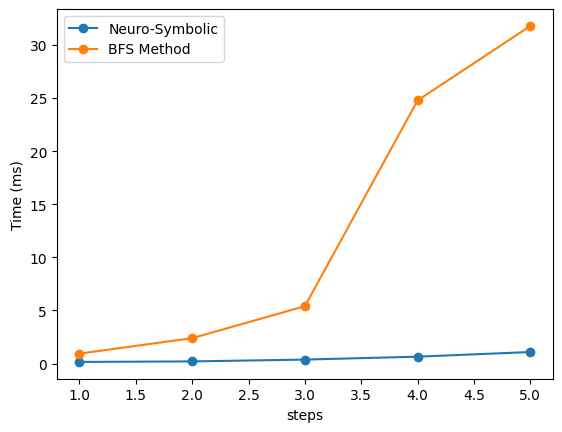

In [114]:
plt.plot([1, 2, 3, 4, 5], [times1[0], times2[0], times3[0], times4[0], times5[0]], marker='o')
plt.plot([1, 2, 3, 4, 5], [times1[1], times2[1], times3[1], times4[1], times5[1]], marker='o');
##~~~~ NN failed for steps = 4 ~~~~~~~~
# plt.scatter(4, times3[0], marker='x', color='red', s=100)
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.ylabel('Time (ms)')
plt.xlabel('steps')
plt.legend(['Neuro-Symbolic', 'BFS Method'])

## Overall Accuracy

In [115]:
# Try transformer model on simple examples  .... 
TrTest_state = test_example(3, XteTR3, True)['state']
TrTest_goal = test_example(3, XteTR3, True)['goal']
f2i = {f:i for i,f in enumerate(ALL_FORMULAS)}
print(TrTest_state, TrTest_goal)

xtokens = np.zeros((11,50), dtype=np.float32)

for t, f in enumerate(TrTest_state):
    xtokens[t, f2i[f]] = 1.0
# print(xtokens)
xtokens[-1, f2i[TrTest_goal]] = 1.0
# print(xtokens)
tt = torch.tensor(xtokens[None,:,:])
print(modelTR5(tt)[0])

x = np.concatenate([encode_state(TrTest_state, ALL_FORMULAS), 
                    encode_state([TrTest_goal], ALL_FORMULAS)])
tt = torch.tensor([x], dtype=torch.float32)

print(modelDS5(tt)[0])

['B->C', 'C->E', 'D->B', 'A&B', 'A|E'] B|E
tensor([  2.0672,  21.4827,   0.1385,  -2.8796,  -1.9166,  -9.3969,  -9.3597,
         -9.2969,  -9.3517,  -9.5080,  -9.2164,  -9.4014,  -9.3560,  -9.2249,
         -9.2040,  -9.4614,  -9.5182,  -9.1692,  -9.2939,  -9.1866,  -9.2965,
         -9.3193,  -9.3901,  -9.5388,  -9.3214,  -9.2525,  -9.2813,  -9.2574,
         -9.3596,  -9.1593,  -6.5852,  -7.2135,  -6.7106, -12.7818, -15.1097,
         -7.1839, -12.2767,  -9.7348, -13.3285,  -7.8564,  -7.4736,  -8.5347,
        -10.4049,  -9.3706,  -5.0247,  -5.2399,  -3.1934,  -8.2552, -12.9517,
         -5.2524], grad_fn=<SelectBackward0>)
tensor([  5.7560,  38.5373,  -7.7935,  -1.5797, -11.0171, -18.0900, -16.1112,
        -20.5384, -19.5829, -16.5611, -18.3851, -17.6082, -16.1208, -14.2104,
        -15.1419, -22.5351, -18.2112, -19.0945, -17.7278, -16.8167, -14.8908,
        -19.5952, -19.5149, -13.9348, -22.7215, -20.5574, -16.4440, -15.0546,
        -16.5453, -10.5973, -41.4366, -56.5628, -53.4

In [116]:
count=0;
for i in range(int(np.shape(XteTR5)[0]/100)):
    TrTest_state = test_example(i, XteTR5, True)['state']
    TrTest_goal = test_example(i, XteTR5, True)['goal']
    print(TrTest_state, TrTest_goal)
    if prove_with_nn(TrTest_state, TrTest_goal, modelTR5, ALL_FORMULAS, True, 5) == True: count += 1
print(count / int(np.shape(XteTR5)[0]/100))

['E', '~B', 'A->B', 'B->D', 'C&E'] B|E
['A->E', 'D->E', 'C&E', 'A|C'] C|E
['E', '~C', 'C->D', 'D->B', 'A&B'] A|B
['D', 'E', 'A->C', 'E->B'] B
['C', 'A->E', 'C->A', 'A&E'] B|E
['A', '~C', 'A|D', 'B|E'] A|C
['B->D', 'D->A', 'C&D'] A&D
['D', 'C->B', 'A&E', 'C&E', 'B|D'] C&D
['C->A', 'B&E', 'C&D', 'B|C', 'C|E'] C
['A->D', 'A&C', 'A&E', 'C&E', 'B|E'] A|C
['C', 'A->D', 'E->C', 'A|D'] C|D
['C->D', 'D->B', 'D->C', 'A&E', 'D&E'] B|C
['E', 'C->E', 'E->B', 'A|B', 'D|E'] B|C
['C->A', 'E->C', 'A&C', 'A|C'] B|C
['B->C', 'A&B', 'B&D', 'C&D', 'B|C'] A|C
['B', 'A->C', 'A->E', 'B->D', 'C->D'] A|B
['D->B', 'D->E', 'A&E', 'C&D', 'C&E'] D&E
['D->E', 'B&D', 'C|E', 'D|E'] A|D
['C->A', 'C->D', 'D->A', 'D->E', 'C&D'] A&D
['A->B', 'C->B', 'A&B', 'B|E'] A|E
['B', '~D', 'B&C', 'C&E'] B|E
['A', 'B&D', 'A|E', 'C|E'] B
['A->C', 'A&C', 'D&E', 'D|E'] A|E
['A', '~B', 'A&D', 'D&E', 'D|E'] A|B
['B', 'A->B', 'C->B', 'C&D'] B|E
['A->E', 'C->B', 'C->D', 'C->E', 'C&E'] A|D
['A->C', 'C->A', 'E->C', 'B&C', 'C&E'] D|E
['B', '~D

In [117]:
count=0;
for i in range(int(np.shape(XteDS1)[0]/100)):
    TrTest_state = test_example(i, XteDS1, False)['state']
    TrTest_goal = test_example(i, XteDS1, False)['goal']
    print(TrTest_state, TrTest_goal)
    if prove_with_nn(TrTest_state, TrTest_goal, modelDS2, ALL_FORMULAS, False, 5) == True: count += 1
print(count / int(np.shape(XteDS1)[0]/100))

['B', 'D->C', 'C&D'] C
['B->D', 'C->D', 'E->D', 'A&B', 'B|E'] A
['B', 'E', 'B->E', 'C->E'] B|D
['A->B', 'A->C', 'E->A', 'A&D', 'C&E'] A
['E', 'D->B', 'E->D', 'A&D'] A
['C->D', 'E->A', 'A&D', 'A|B'] D
['B', 'A->E', 'D->A', 'E->A', 'A|D'] B|D
['A&E', 'D&E', 'B|D', 'D|E'] A
['C', 'C->E', 'B|E', 'C|D'] E
['A->E', 'E->D', 'C&D', 'D|E'] D
['B->D', 'A&D', 'A|C', 'A|E'] D
['B', 'C', '~D', 'C&E'] A|B
['C', 'A->B', 'C->E', 'E->A'] C|E
['B', 'A->D', 'D->C', 'D->E'] B|E
['C', 'A->D', 'A->E', 'E->C', 'E->D'] C|D
['A->D', 'B&E', 'A|E', 'B|D', 'D|E'] B
['~A', 'A->E', 'C->A', 'E->C', 'A|D'] D
['C', 'E', 'A->D', 'A->E'] C|E
['B', 'B->A', 'E->D', 'B&E'] B|C
['C', 'B->A', 'B->E', 'B&D', 'C&E'] E
['~A', 'A->D', 'E->D', 'A|C', 'A|E'] E
['A&C', 'A|B', 'A|E'] A
['B', 'A->D', 'D->B', 'A&C', 'D&E'] B|D
['A', 'A->D', 'C->A', 'B|C'] D
['B->D', 'D->A', 'A&E', 'C&D', 'D|E'] E
['A->E', 'D->A', 'C&E', 'B|D'] E
['D', '~A', 'C->B', 'D&E'] D|E
['A', 'B', 'B->E', 'C&D', 'B|D'] A|D
['A', 'B', 'C', 'E', 'A|C'] B&E
['B', '

In [118]:
def prove_with_nn(state, goal, model, ALL_FORMULAS, transformer, max_steps=5):
    '''
    Returns True if TheoremProver2 is successful AND has correct # of steps
    Returns False if not
    '''
    state = list(state)
    
    # True shortest depth
    true_path = find_shortest_proof(state, goal, ALL_FORMULAS, 5)
    if true_path is None: return False
    true_depth = len(true_path)
    
    proved, steps = TheoremProver2(state, goal, model, ALL_FORMULAS, transformer)
    return proved and (steps == true_depth)

In [119]:
def check_GlobalAcc_NN(Xtest, model, transformer):
    correct = 0
    total = len(Xtest)
    for i in range(total):
        state, goal = test_example(i, Xtest)['state'],  test_example(i, Xtest)['goal']
        if prove_with_nn(state, goal, model, ALL_FORMULAS, transformer): # if NN can prove goal ... 
            correct += 1
    print("Global Proof Accuracy:", correct, "/", total, "=", correct/total)

# check_GlobalAcc_NN(Xte1, modelTR1, True)
# check_GlobalAcc_NN(Xte2, model2)
# check_GlobalAcc_NN(Xte3, model3)
# check_GlobalAcc_NN(Xte4, model4)
# check_GlobalAcc_NN(Xte5, model5)
# check_GlobalAcc_NN(Xte2, modelDS2)
# check_GlobalAcc_NN(Xte3, modelDS3)
# check_GlobalAcc_NN(Xte4, modelDS4)
# check_GlobalAcc_NN(Xte5, modelDS5)

In [64]:
def precompute_depth_idxs(Xte, ALL_FORMULAS, transformer, cap, max_depth=6):
    true_depths = []
    for i in range(len(Xte)):
        if i % 10000 == 0: print(f'{i} out of {len(Xte)}')
        state, goal = test_example(i, Xte, transformer)['state'], test_example(i, Xte, transformer)['goal']
        d = len(find_shortest_proof(state, goal, ALL_FORMULAS, max_depth))
        true_depths.append(d)

    depth_to_idxs = {}
    for i, d in enumerate(true_depths):
        depth_to_idxs.setdefault(d, [])
        if len(depth_to_idxs[d]) < cap:
            depth_to_idxs[d].append(i)
    return depth_to_idxs
def accuracy_by_depth_from_idxs(Xte, model, ALL_FORMULAS, transformer, depth_to_idxs):
    results = {}
    for d in sorted(depth_to_idxs):
        print(f'on depth {d}')
        idxs = depth_to_idxs[d]
        correct = 0
        for i in idxs:
            state, goal = test_example(i, Xte, transformer)['state'], test_example(i, Xte, transformer)['goal']
            if prove_with_nn(state, goal, model, ALL_FORMULAS, transformer):
                correct += 1
        results[d] = correct / len(idxs)
    return results

In [65]:
depth_to_idxs = precompute_depth_idxs(Xte5, ALL_FORMULAS, False, cap=800)

0 out of 200001
10000 out of 200001
20000 out of 200001
30000 out of 200001
40000 out of 200001
50000 out of 200001
60000 out of 200001
70000 out of 200001
80000 out of 200001
90000 out of 200001
100000 out of 200001
110000 out of 200001
120000 out of 200001
130000 out of 200001
140000 out of 200001
150000 out of 200001
160000 out of 200001
170000 out of 200001
180000 out of 200001
190000 out of 200001
200000 out of 200001


In [66]:
depth_to_idxs.keys()

dict_keys([1, 2, 3, 4, 5])

In [161]:
## Accuracy for MLPs
acc1 = accuracy_by_depth_from_idxs(Xte5, model1, ALL_FORMULAS, False, depth_to_idxs)
acc2 = accuracy_by_depth_from_idxs(Xte5, model2, ALL_FORMULAS, False, depth_to_idxs)
acc3 = accuracy_by_depth_from_idxs(Xte5, model3, ALL_FORMULAS, False, depth_to_idxs)
acc4 = accuracy_by_depth_from_idxs(Xte5, model4, ALL_FORMULAS, False, depth_to_idxs)
acc5 = accuracy_by_depth_from_idxs(Xte5, model5, ALL_FORMULAS, False, depth_to_idxs)
print(acc1)
print(acc2)
print(acc3)
print(acc4)
print(acc5)

on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
{1: 1.0, 2: 0.81, 3: 0.32375, 4: 0.1125, 5: 0.01625}
{1: 0.99875, 2: 0.99875, 3: 0.97875, 4: 0.75625, 5: 0.385}
{1: 0.99875, 2: 0.99625, 3: 0.97625, 4: 0.96875, 5: 0.94}
{1: 1.0, 2: 0.99875, 3: 0.995, 4: 0.975, 5: 0.97625}
{1: 1.0, 2: 0.995, 3: 0.99375, 4: 0.9775, 5: 0.96}


In [162]:
## Accuracy for Deep Sets
accDS1 = accuracy_by_depth_from_idxs(XteDS5, modelDS1, ALL_FORMULAS, False, depth_to_idxs)
accDS2 = accuracy_by_depth_from_idxs(XteDS5, modelDS2, ALL_FORMULAS, False, depth_to_idxs)
accDS3 = accuracy_by_depth_from_idxs(XteDS5, modelDS3, ALL_FORMULAS, False, depth_to_idxs)
accDS4 = accuracy_by_depth_from_idxs(XteDS5, modelDS4, ALL_FORMULAS, False, depth_to_idxs)
accDS5 = accuracy_by_depth_from_idxs(XteDS5, modelDS5, ALL_FORMULAS, False, depth_to_idxs)
print(accDS1)
print(accDS2)
print(accDS3)
print(accDS4)
print(accDS5)

on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
{1: 1.0, 2: 0.495, 3: 0.10625, 4: 0.01875, 5: 0.0}
{1: 0.99875, 2: 1.0, 3: 1.0, 4: 0.94625, 5: 0.87125}
{1: 0.99875, 2: 0.99625, 3: 0.9875, 4: 0.9825, 5: 0.97125}
{1: 1.0, 2: 0.9975, 3: 0.98375, 4: 0.96875, 5: 0.9}
{1: 1.0, 2: 1.0, 3: 0.99, 4: 0.9675, 5: 0.88625}


In [154]:
## Accuracy for Transformers
accTR1 = accuracy_by_depth_from_idxs(XteTR5, modelTR1, ALL_FORMULAS, True, depth_to_idxs)
accTR2 = accuracy_by_depth_from_idxs(XteTR5, modelTR2, ALL_FORMULAS, True, depth_to_idxs)
accTR3 = accuracy_by_depth_from_idxs(XteTR5, modelTR3, ALL_FORMULAS, True, depth_to_idxs)
accTR4 = accuracy_by_depth_from_idxs(XteTR5, modelTR4, ALL_FORMULAS, True, depth_to_idxs)
accTR5 = accuracy_by_depth_from_idxs(XteTR5, modelTR5, ALL_FORMULAS, True, depth_to_idxs)
print(accTR1)
print(accTR2)
print(accTR3)
print(accTR4)
print(accTR5)

on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
on depth 1
on depth 2
on depth 3
on depth 4
on depth 5
{1: 1.0, 2: 0.66, 3: 0.35875, 4: 0.09625, 5: 0.01625}
{1: 1.0, 2: 1.0, 3: 0.9975, 4: 0.8725, 5: 0.59}
{1: 1.0, 2: 1.0, 3: 0.9975, 4: 0.9875, 5: 0.97375}
{1: 1.0, 2: 1.0, 3: 1.0, 4: 0.99625, 5: 0.97}
{1: 1.0, 2: 1.0, 3: 1.0, 4: 0.99625, 5: 0.975}


In [155]:
accs = [acc1, acc2, acc3, acc4, acc5]
accsDS = [accDS1, accDS2, accDS3, accDS4, accDS5]
accsTR = [accTR1, accTR2, accTR3, accTR4, accTR5]
labels = ["Depth ≤1", "Depth ≤2", "Depth ≤3", "Depth ≤4", "Depth ≤5",]

# Collect union of depths that appear
all_depths = sorted(set().union(
    *[acc.keys() for acc in accs],
    *[acc.keys() for acc in accsDS],
    *[acc.keys() for acc in accsTR],
))
print(all_depths)

[1, 2, 3, 4, 5]


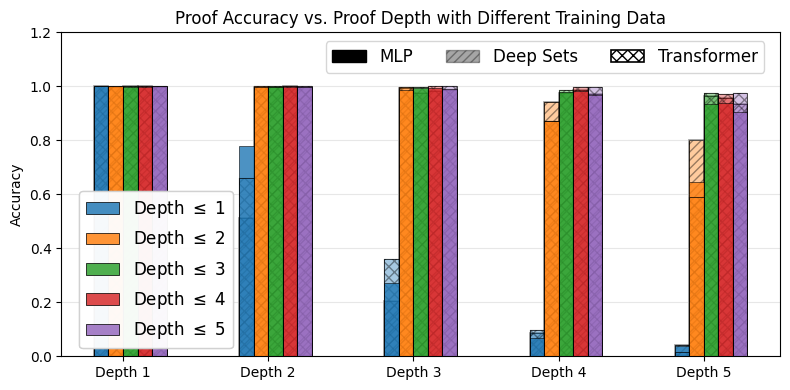

In [181]:
data = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accs])
data_DS = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accsDS])
data_TR = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accsTR])


# --- Plot ---
x = np.arange(len(all_depths))            # depth positions
width = 0.1                               # bar width

plt.figure(figsize=(8,4))
bars = []
for i in range(len(accs)):
    b = plt.bar(x + i*width, data[i], width, label=labels[i],
                edgecolor='k', alpha=0.8, linewidth=0.5, zorder=3)   # MLP = solid
    bars.append(b)

for i in range(len(accsDS)):
    c = bars[i].patches[0].get_facecolor()
    plt.bar(x + i*width, data_DS[i], width,
            label=labels[i] + " (DS)",
            facecolor=c, edgecolor='k', alpha=0.4, linewidth=1.2,
            hatch='////', zorder=1)                               # DS = hatched
    plt.bar(x + i*width, data_DS[i], width,
            facecolor='none', edgecolor='k', alpha=1, linewidth=0.5,
             zorder=1, label='_nolegend_') 

# for i in range(len(accsTR)):
#     c = bars[i].patches[0].get_facecolor()
#     plt.bar(x + i*width, data_TR[i], width,
#             label=labels[i] + " (TR)",
#             facecolor=c, edgecolor='k', alpha=0.4, linewidth=1.2,
#             hatch='xxx', zorder=2)                                # TR = outline + hatch
for i in range(len(accsTR)):
    c = bars[i].patches[0].get_facecolor()
    plt.bar(x + i*width, data_TR[i], width,
            label=labels[i] + " (TR)",
            facecolor=c, edgecolor='k', alpha=0.4, linewidth=0.2,
            hatch='xxx', zorder=2)
    plt.bar(x + i*width, data_TR[i], width,
            facecolor='none', edgecolor='k', alpha=1.0, linewidth=0.5,
            zorder=3, label='_nolegend_')

plt.xticks(x + width*1.5, [f"Depth {d}" for d in all_depths])
plt.ylabel("Accuracy")
plt.ylim(0,1.2)

# --- Legends ---
mlp_patch = Patch(facecolor='k', edgecolor='k', alpha=1, label='MLP')
ds_patch  = Patch(facecolor='k', edgecolor='k', alpha=0.35, hatch='////', label='Deep Sets')
tr_patch  = Patch(facecolor='none', edgecolor='k', linewidth=1.2, hatch='xxx', label='Transformer')

depth_handles = [
    Patch(facecolor=bars[i].patches[0].get_facecolor(),
          edgecolor='k', linewidth=0.5,
          label=rf"Depth $\leq$ {i+1}")
    for i in range(len(bars))
]

leg1 = plt.legend(handles=[mlp_patch, ds_patch, tr_patch], fontsize=12,
                  loc='lower right', ncol=3, bbox_to_anchor=(0.99, 0.85))
leg2 = plt.legend(handles=depth_handles, fontsize=12,
                  loc='lower right', ncol=1, bbox_to_anchor=(0.25, 0.0))
plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

plt.title("Proof Accuracy vs. Proof Depth with Different Training Data")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('Plots/Accuracy_vs_Depth.png')

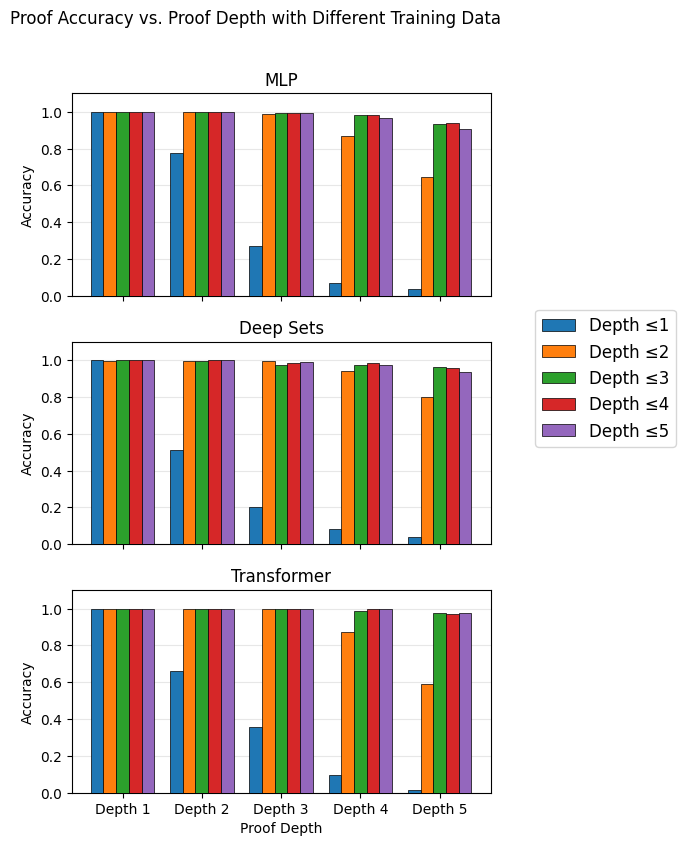

In [180]:
data = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accs])
data_DS = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accsDS])
data_TR = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accsTR])

# --- Plot (3 stacked subplots) ---
x = np.arange(len(all_depths)) + 1
n_series = len(accs)
width = 0.8 / max(n_series, 1)

# (S, D) so offsets[i] is the x-positions for series i across all depths
offsets = np.vstack([x + (i - (n_series - 1)/2)*width for i in range(n_series)])

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(5, 9))

# ---------- 1) MLP ----------
series_colors = []
for i in range(n_series):
    b = ax[0].bar(offsets[i], data[i], width, label=labels[i],
                  edgecolor='k', alpha=1, linewidth=0.5, zorder=3)
    series_colors.append(b.patches[0].get_facecolor())

ax[0].set_title("MLP")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 1.1)
ax[0].grid(axis='y', alpha=0.3)

# ---------- 2) Deep Sets ----------
for i in range(min(len(accsDS), n_series)):
    ax[1].bar(offsets[i], data_DS[i], width,
              edgecolor='k', alpha=1, linewidth=0.5, zorder=3)

ax[1].set_title("Deep Sets")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim(0, 1.1)
ax[1].grid(axis='y', alpha=0.3)

# ---------- 3) Transformer ----------
for i in range(min(len(accsTR), n_series)):
    c = series_colors[i]
    ax[2].bar(offsets[i], data_TR[i], width,
              facecolor=c, edgecolor='k', alpha=1, linewidth=0.5, zorder=3)

ax[2].set_title("Transformer")
ax[2].set_ylabel("Accuracy")
ax[2].set_ylim(0, 1.1)
ax[2].grid(axis='y', alpha=0.3)

# ----- error bars: ---------------
# j = all_depths.index(5)
# N5 = int(0.2 * list(depths).count(5))   # your depth=5 test-set size
# N5 = max(N5, 1)                         # avoid divide-by-zero

# for i in range(n_series):
#     p = data[i, j]
#     if np.isfinite(p):
#         ax[0].errorbar(
#             offsets[i, j], p,
#             yerr=np.sqrt(p * (1 - p) / N5),
#             fmt='none', ecolor='k', elinewidth=1, capsize=3, zorder=10
#         )

# for i in range(min(len(accsDS), n_series)):
#     p = data_DS[i, j]
#     if np.isfinite(p):
#         ax[1].errorbar(
#             offsets[i, j], p,
#             yerr=np.sqrt(p * (1 - p) / N5),
#             fmt='none', ecolor='k', elinewidth=1, capsize=3, zorder=10)

# for i in range(min(len(accsTR), n_series)):
#     p = data_TR[i, j]
#     if np.isfinite(p):
#         ax[2].errorbar(
#             offsets[i, j], p,
#             yerr=np.sqrt(p * (1 - p) / N5),
#             fmt='none', ecolor='k', elinewidth=1, capsize=3, zorder=10)

# shared x formatting
ax[2].set_xticks(x)
ax[2].set_xticklabels([f"Depth {d}" for d in all_depths])
ax[2].set_xlabel("Proof Depth")

# one shared legend (depth-series colors)
depth_handles = [
    Patch(facecolor=series_colors[i], edgecolor='k', linewidth=0.5, label=labels[i])
    for i in range(n_series)
]
fig.legend(handles=depth_handles, fontsize=12,
           loc='lower center',
           bbox_to_anchor=(1.2, 0.5))

fig.suptitle("Proof Accuracy vs. Proof Depth with Different Training Data", y=0.995)
fig.tight_layout(rect=(0, 0.06, 1, 0.98))

plt.savefig('Plots/Accuracy_vs_Depth_Separate.png', dpi=300, bbox_inches='tight')
plt.show()
